## Party Groupings in Papers

Here, we look briefly at groupings among parties to various papers. What countries put their names together?

We start by meeting basic requirements:

In [1]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install python-igraph
!{sys.executable} -m pip install pycairo

You should consider upgrading via the '/home/g/.pyenv/versions/3.8.2/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/g/.pyenv/versions/3.8.2/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/g/.pyenv/versions/3.8.2/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/g/.pyenv/versions/3.8.2/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 344 kB 1.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Command errored out with exit status 1:
   command: /home/g/.pyenv/versions/3.8.2/bin/python /home/g/.local/lib/python3.8/site-packages/pip/_vendor/pep517/in_process/_in_process.py build_wheel /tmp/tmp2jwdijch
       cwd: /tmp/pip-install-r7r92vhz/pycairo_6fb1509edbbb45bcbf1a1416f9bde4f0
  Complete output (15 lines):
  running bdi

In [2]:
import numpy as np
import pandas as pd
import igraph as ig

The raw data:

In [3]:
df = pd.read_pickle('../data/processed/documents/ats_documents.pkl')

In [4]:
df.head()

,filename,extension,meeting,paper_type_abbreviation,paper_number,paper_revision,paper_language_abbreviation,raw_text,meeting_year,paper_name,paper_id,paper_type_id,meeting_type,meeting_id,meeting_number,meeting_name,parties
0,ATIP2020_ip031_r.doc,doc,ATIP2020,ip,031,0,r,- About\n\n - The Antarctic Treaty\n\n ...,2020.0,Non-native species Trichocera maculipennis (Di...,11545.0,2.0,ATIP,91.0,2020,ATIP 2019/2021,Poland
1,ATCM21_ip081_e.pdf,pdf,ATCM21,ip,081,0,e,ANTARCTIC TREATY ...,1997.0,Opening address by Head of the delegation of P...,7360.0,2.0,ATCM,51.0,21,ATCM XXI,Poland
2,ATME1989_wp012_e.pdf,pdf,ATME1989,wp,012,0,e,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,1989.0,Answer to the questionnaire (Recommendation XI...,6062.0,1.0,ATME,67.0,1989,ME Air Safety,United States
3,ATCM38_bp021_r.doc,doc,ATCM38,bp,021,0,r,- About\n\n - The Antarctic Treaty\n\n ...,2015.0,Workshop on Education and Outreach – Poster Ab...,7749.0,9.0,ATCM,80.0,38,ATCM XXXVIII - CEP XVIII,Bulgaria
4,ATCM29_wp018_s.doc,doc,ATCM29,wp,018,0,s,Establecimiento de zonas de interés turístico\...,2006.0,Establishment of “areas of special tourist int...,739.0,1.0,ATCM,60.0,29,ATCM XXIX - CEP IX,France


In [5]:
df_english = df[df.paper_language_abbreviation == 'e'] # we're just looking at english papers for now
papers_and_parties = [{"paper_id":x['paper_id'], "parties":x['parties'].split(', ')} for i,x in df_english.iterrows() if isinstance(x['parties'], str) and len(x['parties'])>0 and isinstance(x['paper_id'], float)]

In [6]:
pp_df = pd.DataFrame(papers_and_parties)
all_parties = [r['parties'] for i,r in pp_df.iterrows()]
all_parties = [p for parties in all_parties for p in parties]
all_parties = list(set(all_parties))

We can slice this up into two (naive) graphs, here. The first, papers that are connected to one another by parties. Second, more importantly for our purposes, parties that are connected to one another by papers.

We start by collecting the edges:

In [7]:
from itertools import combinations

paper_edges = [(r['paper_id'], list(combinations(r['parties'],2))) for i,r in pp_df.iterrows()]
paper_edges = [pe for pe in paper_edges if len(pe[1])>0]
paper_edges

[(6532.0, [('Argentina', 'IAATO')]),
 (2103.0, [('IPY-IPO', 'SCAR')]),
 (11187.0,
  [('Australia', 'China'),
   ('Australia', 'India'),
   ('Australia', 'Russian Federation'),
   ('China', 'India'),
   ('China', 'Russian Federation'),
   ('India', 'Russian Federation')]),
 (3736.0, [('United Kingdom', 'United States')]),
 (11152.0, [('United Kingdom', 'IAATO')]),
 (7109.0, [('France', 'New Zealand')]),
 (3366.0, [('Australia', 'Netherlands')]),
 (5682.0, [('Russian Federation', 'United States')]),
 (1921.0,
  [('Belgium', 'Chile'),
   ('Belgium', 'France'),
   ('Belgium', 'Germany'),
   ('Belgium', 'Italy'),
   ('Belgium', 'Netherlands'),
   ('Belgium', 'South Africa'),
   ('Chile', 'France'),
   ('Chile', 'Germany'),
   ('Chile', 'Italy'),
   ('Chile', 'Netherlands'),
   ('Chile', 'South Africa'),
   ('France', 'Germany'),
   ('France', 'Italy'),
   ('France', 'Netherlands'),
   ('France', 'South Africa'),
   ('Germany', 'Italy'),
   ('Germany', 'Netherlands'),
   ('Germany', 'South A

In [8]:
paper_edges_flattened = []
for paper_edge_list in paper_edges:
    paper_id = paper_edge_list[0]
    all_edges = paper_edge_list[1]
    for edge in all_edges:
        paper_edges_flattened.append((paper_id, edge))

We can now put this into a graph structure, with 'paper_id' as an edge property.

In [9]:
g = ig.Graph(directed=False)
g.add_vertices(all_parties)
g.add_edges([pe[1] for pe in paper_edges_flattened])
g.es["paper_id"] = [pe[0] for pe in paper_edges_flattened]

Is there an obvious structure here?

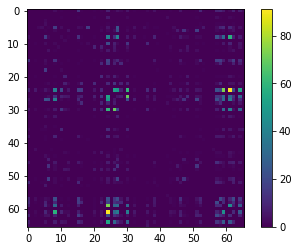

In [10]:
import matplotlib.pyplot as plt
plt.imshow(np.matrix(g.get_adjacency().data))
plt.colorbar()
plt.show()

Yes, and it looks like extremistan. Let's sanity check this, though: what does the curve look like?

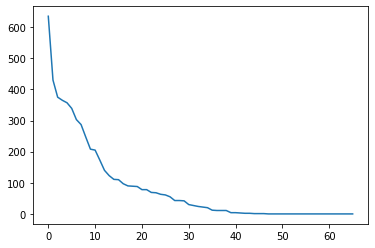

In [26]:
plt.plot(sorted(g.vs.degree(), reverse=True))

Honestly, not as extreme as I was expecting.

Who is 'most connected' in this degree centrality sense?

In [27]:
# The top most 'connected' country (by degree):
g.vs.select(_degree=g.maxdegree())['name']

['United Kingdom']

In [12]:
# The degree of that country:
g.maxdegree()

635

Because we're counting 'duplicate' connections among countries as separate edges, the natural language way of describing this is something like: 'this is the country that tends to put its name with other countries the most'.

Similarly, we can talk about the parties that *never* put their name on treaty papers with other countries:

In [13]:
# The totally disconnected parties:
g.vs.select(_degree=0)['name']

['IGP&I Clubs',
 'ATS',
 'Switzerland',
 'Kazakhstan',
 'IOPC Funds',
 'WTO',
 'IMO',
 'ACAP',
 'Denmark',
 'Greece',
 'Iceland',
 'ICAO',
 'Slovakia',
 'Estonia',
 'Korea (DPRK)',
 'IPCC',
 'Malaysia',
 'Austria',
 'IOC']

Thanks to this 'centre/'periphery' dynamic, I expect any normal viz --- even one simplified to exclude the totally disconnected parties and the 'we share lots of the same papers' duplication --- to look messy.

A simplified graph (with the disconnected parties removed) basically supports the instinct. First, we rebuild a version of the graph *with simplification and deduplication*:

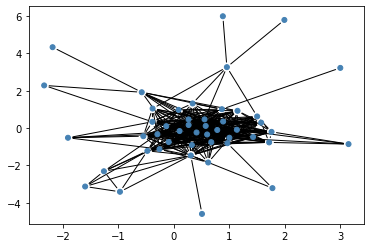

In [14]:
fig, ax = plt.subplots()

g_simple = ig.Graph(directed=False)
g_simple.add_vertices(all_parties)
g_simple.add_edges([pe[1] for pe in paper_edges_flattened])
g_simple.es["paper_id"] = [pe[0] for pe in paper_edges_flattened]
g_simple.simplify()
g_simple.delete_vertices([v.index for v in g_simple.vs.select(_degree=0)])
layout = g_simple.layout('fr')
ig.plot(g_simple, target = ax, layout = layout)

And for reference, the unsimplified version:

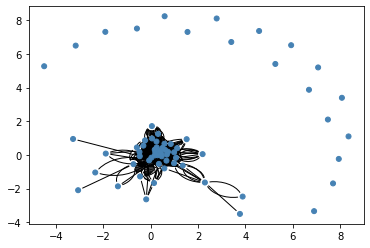

In [15]:
fig, ax = plt.subplots()
layout = g.layout('fr')
ig.plot(g, target = ax, layout = layout)

And here, the matrix for the simplified graph (for comparison to the above one):

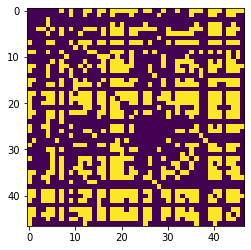

In [16]:
plt.imshow(np.matrix(g_simple.get_adjacency().data))
plt.show()

In [17]:
g_simple.vs.select(_degree=g_simple.maxdegree())['name']

['United Kingdom', 'Chile', 'France']